In [317]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from datetime import datetime as dt

FIGSIZE = (20, 6)

In [318]:
years = [i.name for i in os.scandir(f"inmet-data") if i.is_dir()]
location = "A801"

filenames = []
for year in years:
    filenames.extend(
        [
            f"{year}/{file.name}"
            for file in os.scandir(f"inmet-data/{year}")
            if location in file.name
        ]
    )

filenames.sort()

dfs = []
for f in filenames:
    df = pd.read_csv(f"inmet-data/{f}", delimiter=";", header=8, encoding="iso-8859-1")
    dfs.append(
        df.rename(
            columns={
                "HORA (UTC)": "Hora UTC",
                "DATA (YYYY-MM-DD)": "Data",
                "RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)",
            }
        )
    )

raw_data = pd.concat(dfs).reset_index()
raw_data

,index,Data,Hora UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
0,0,2000-09-22,00:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
1,1,2000-09-22,01:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
2,2,2000-09-22,02:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
3,3,2000-09-22,03:00,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999,NaN
4,4,2000-09-22,04:00,0,"1013,9","1014,2","1013,2",-9999,"15,5","14,6",...,"15,5","14,8","14,6",95.0,94.0,94.0,231.0,"4,4","1,2",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209131,5107,2024/07/31,1900 UTC,0,"1014,8","1014,9","1014,8","1501,3","22,5","12,2",...,"22,4",13,"11,1",54.0,46.0,52.0,79.0,"3,4","1,2",NaN
209132,5108,2024/07/31,2000 UTC,0,"1014,2","1014,8","1014,2",642,"21,5","11,9",...,"21,5","12,8","11,4",56.0,49.0,54.0,92.0,"3,6","1,1",NaN
209133,5109,2024/07/31,2100 UTC,0,"1014,4","1014,4","1014,2","50,8","18,9","12,5",...,"18,9","12,5","11,7",66.0,54.0,66.0,129.0,"3,1","1,1",NaN
209134,5110,2024/07/31,2200 UTC,0,"1014,7","1014,7","1014,4",NaN,"17,8","13,5",...,"17,7","13,5","12,5",76.0,66.0,76.0,111.0,"3,2",1,NaN


In [319]:
cols = raw_data.columns

# treating hour data bc it's not super consistent
raw_data[cols[2]] = raw_data[cols[2]].apply(
    lambda s: ":".join([s[:2], s[2:4]]) if isinstance(s, str) and "UTC" in s else s
)
# same for dates
raw_data[cols[1]] = raw_data[cols[1]].apply(
    lambda s: s.replace("/", "-") if isinstance(s, str) else s
)


raw_data["datetime"] = pd.to_datetime(
    raw_data[cols[1]] + " " + raw_data[cols[2]], format="%Y-%m-%d %H:%M"
)


def parseToFloat(col):
    return (
        raw_data[col]
        .apply(lambda x: np.float64(x.replace(",", ".")) if (isinstance(x, str)) else x)
        .apply(lambda x: np.nan if x == -9999.0 else x)
    )


# global-radiation
raw_data["global-radiation"] = parseToFloat(cols[7])

# precipitation
raw_data["total-precipitation"] = parseToFloat(cols[3])

raw_data["relative-humidity"] = parseToFloat("UMIDADE RELATIVA DO AR, HORARIA (%)")

# temperature
raw_data["temperature-last-hour-max"] = parseToFloat(
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)"
)
raw_data["temperature-last-hour-min"] = parseToFloat(
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"
)

# wind
raw_data["wind-speed"] = parseToFloat("VENTO, VELOCIDADE HORARIA (m/s)")
raw_data["wind-speed-max-gust"] = parseToFloat("VENTO, RAJADA MAXIMA (m/s)")

raw_data
# removing unused columns and renaming the remainder to more friendly names
renamed_data = raw_data.drop(columns=cols[:21]).set_index("datetime")
renamed_data["datetime"] = renamed_data.index
renamed_data

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust,datetime
datetime,,,,,,,,
2000-09-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 00:00:00
2000-09-22 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 01:00:00
2000-09-22 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 02:00:00
2000-09-22 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000-09-22 03:00:00
2000-09-22 04:00:00,NaN,0.0,94.0,15.6,15.5,1.2,4.4,2000-09-22 04:00:00
...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,1501.3,0.0,52.0,23.7,22.4,1.2,3.4,2024-07-31 19:00:00
2024-07-31 20:00:00,642.0,0.0,54.0,22.6,21.5,1.1,3.6,2024-07-31 20:00:00
2024-07-31 21:00:00,50.8,0.0,66.0,21.5,18.9,1.1,3.1,2024-07-31 21:00:00


In [320]:
target = "global-radiation"
idx = "datetime"

df = renamed_data

by_day = (
    renamed_data.groupby([df.index.year, df.index.day_of_year]).mean().set_index(idx)
)

by_day = by_day.loc[by_day[target].notna()]
by_day

,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
datetime,,,,,,,
2000-09-22 11:30:00,1709.000000,0.000000,69.150000,17.645000,16.665000,1.830000,4.950000
2000-09-23 11:30:00,1621.166667,1.166667,76.125000,18.170833,16.875000,1.558333,4.529167
2000-09-24 11:30:00,519.857143,0.991667,80.750000,15.516667,14.641667,2.454167,7.358333
2000-09-25 11:30:00,1821.769231,0.000000,61.458333,11.275000,10.229167,2.733333,7.195833
2000-09-26 11:30:00,1838.307692,0.000000,63.458333,12.283333,11.295833,1.750000,4.679167
...,...,...,...,...,...,...,...
2024-07-27 11:30:00,571.772727,0.025000,90.583333,17.170833,16.529167,0.820833,2.675000
2024-07-28 11:30:00,166.763636,0.200000,94.875000,15.708333,15.366667,1.233333,4.470833
2024-07-29 11:30:00,294.172727,0.783333,88.708333,12.475000,11.945833,1.620833,6.629167


,global-radiation,total-precipitation,relative-humidity,temperature-last-hour-max,temperature-last-hour-min,wind-speed,wind-speed-max-gust
count,8586.000000,8585.000000,8586.000000,8584.000000,8584.000000,8567.000000,8564.000000
mean,1178.104363,0.171917,75.938249,20.492739,19.480047,1.540258,4.789913
std,555.943118,0.454139,9.363295,4.807141,4.690955,0.617559,1.674359
min,0.000000,0.000000,38.541667,5.912500,4.816667,0.120000,0.800000
25%,755.509615,0.000000,69.291667,17.119792,16.224185,1.100000,3.595833
50%,1191.456667,0.000000,75.875000,20.987500,19.950000,1.437500,4.591667
75%,1619.230769,0.075000,82.541667,24.225000,23.146280,1.864188,5.734375
max,2290.428571,6.600000,99.916667,33.900000,32.408333,4.983333,13.862500


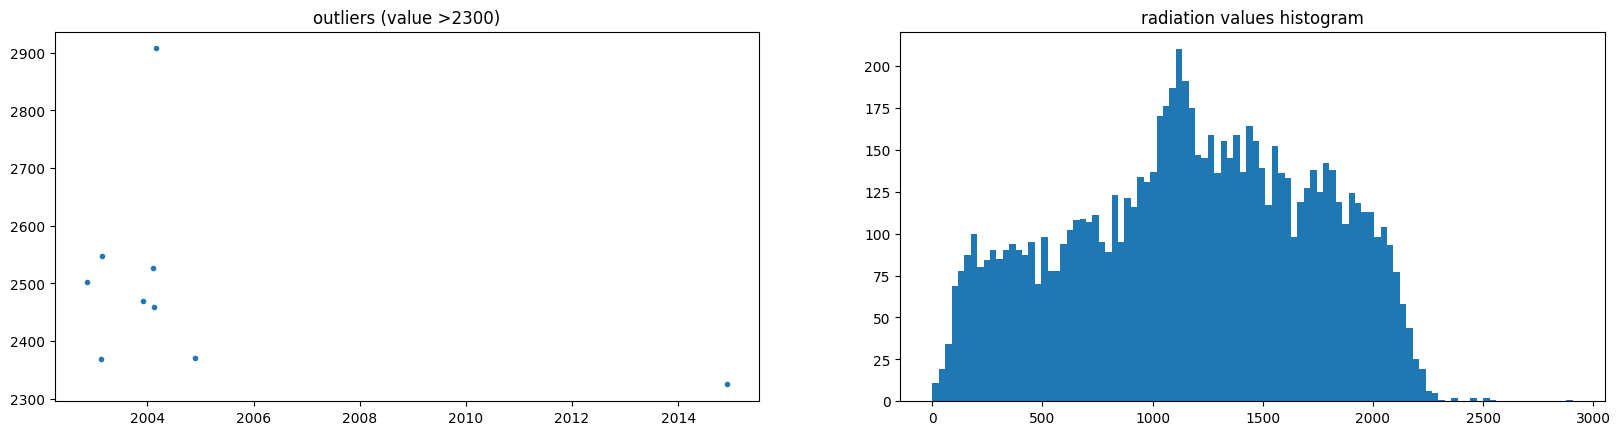

In [321]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(20)
cap = 2300

ax[0].set_title(f"outliers (value >{cap})")
ax[0].plot(by_day.loc[by_day[target] > cap, target], ".")

ax[1].set_title("radiation values histogram")
ax[1].hist(by_day[target], 100)

by_day = by_day.loc[by_day[target] < cap]
by_day.describe()

'len(train) = 7986\nlen(test) = 364'

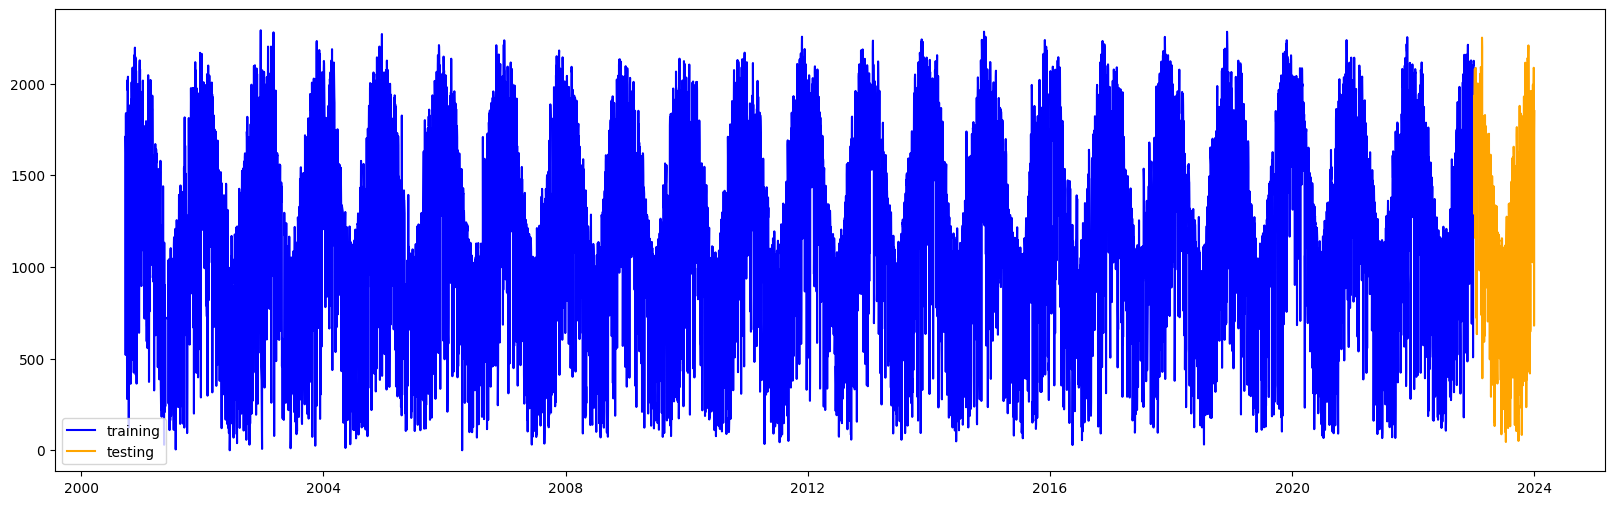

In [322]:
date_threshold, date_mask = "2023", "%Y"
date_upper_threshold = str(int(date_threshold) + 1)


def training_threshold(col):
    return col <= pd.to_datetime(date_threshold, format=date_mask)


def testing_treshold(col):
    return ~training_threshold(col) & (
        col <= pd.to_datetime(date_upper_threshold, format=date_mask)
    )


def split_datasets(df):
    return (
        df[training_threshold(df.index)].dropna(),
        df[testing_treshold(df.index)].dropna(),
    )


train, test = split_datasets(by_day)

plt.figure(figsize=FIGSIZE)
plt.plot(train[target], color="blue", label="training")
plt.plot(test[target], color="orange", label="testing")
plt.legend()

f"len(train) = {train[target].size}\nlen(test) = {test[target].size}"

In [323]:
window_size = 49


def make_rolling_window(df, window_size=window_size):
    return df.rolling(window=window_size).mean().copy()


def reset_time(df):
    df[idx] = df.index
    df[idx] = df[idx].apply(lambda t: t.replace(hour=0, minute=0, second=0))
    return df.set_index(idx)


train_rolling = make_rolling_window(train)
train_rolling = reset_time(train_rolling)

test_rolling = make_rolling_window(test)
test_rolling = reset_time(test_rolling)

In [324]:
fit_data = pd.DataFrame(dict(ds=train_rolling.index, y=train_rolling[target]))

from prophet import Prophet

reg = Prophet()
reg.fit(fit_data)

13:54:55 - cmdstanpy - INFO - Chain [1] start processing
13:54:56 - cmdstanpy - INFO - Chain [1] done processing


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,10486,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.000000,10486.0,10486.0,10486.0,10486.000000
mean,2015-07-21 17:59:55.880221184,1192.049148,1053.495553,1333.612541,1139.225393,1244.419572,1.567639,1.567639,1.567639,0.000537,0.000537,0.000537,1.567102,1.567102,1.567102,0.0,0.0,0.0,1193.616787
min,2000-11-10 00:00:00,1106.212464,249.685844,748.522743,672.740493,1106.212464,-452.763236,-452.763236,-452.763236,-0.285205,-0.285205,-0.285205,-452.478031,-452.478031,-452.478031,0.0,0.0,0.0,656.016929
25%,2008-05-17 06:00:00,1162.083440,782.898346,1059.212151,1119.805648,1162.083440,-265.496533,-265.496533,-265.496533,-0.227818,-0.227818,-0.227818,-265.586139,-265.586139,-265.586139,0.0,0.0,0.0,925.618060
50%,2015-07-24 12:00:00,1216.668382,1053.439377,1348.843104,1166.482888,1216.668382,-0.555889,-0.555889,-0.555889,0.011342,0.011342,0.011342,-0.299377,-0.299377,-0.299377,0.0,0.0,0.0,1193.121722
75%,2022-10-18 18:00:00,1227.255307,1361.074198,1607.928286,1217.787429,1241.391402,325.379401,325.379401,325.379401,0.168132,0.168132,0.168132,325.287515,325.287515,325.287515,0.0,0.0,0.0,1489.248838
max,2029-12-22 00:00:00,1263.826057,1527.378928,2179.247119,1263.826057,1791.207109,378.707737,378.707737,378.707737,0.261423,0.261423,0.261423,378.446314,378.446314,378.446314,0.0,0.0,0.0,1621.714475
std,NaN,42.581663,307.912477,314.660363,113.954621,148.302764,293.520636,293.520636,293.520636,0.190971,0.190971,0.190971,293.520662,293.520662,293.520662,0.0,0.0,0.0,295.707175


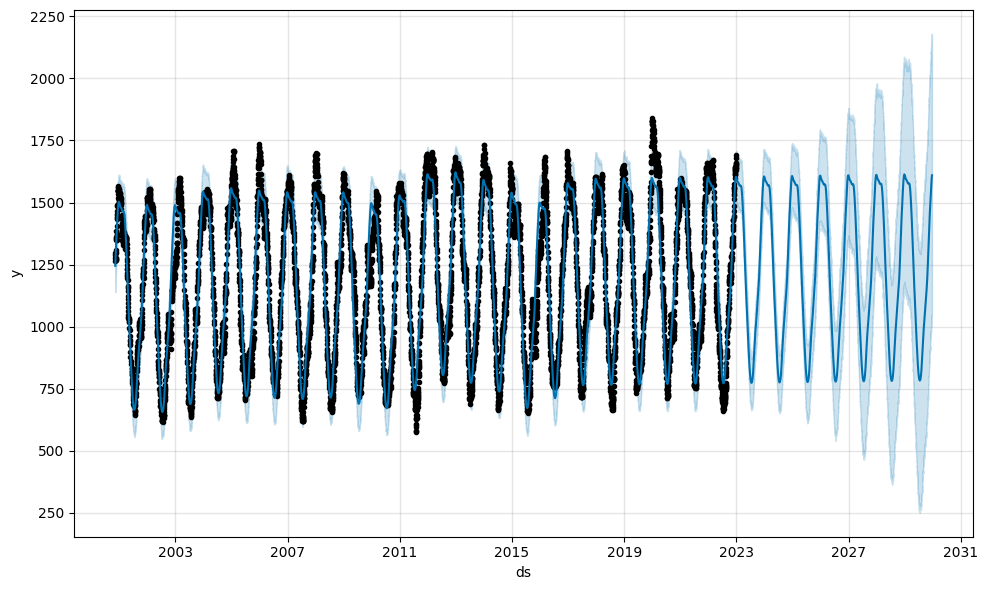

In [325]:
prediction_size = test_rolling.size
future = reg.make_future_dataframe(periods=prediction_size)
forecast = reg.predict(future)

reg.plot(forecast)
forecast.describe()

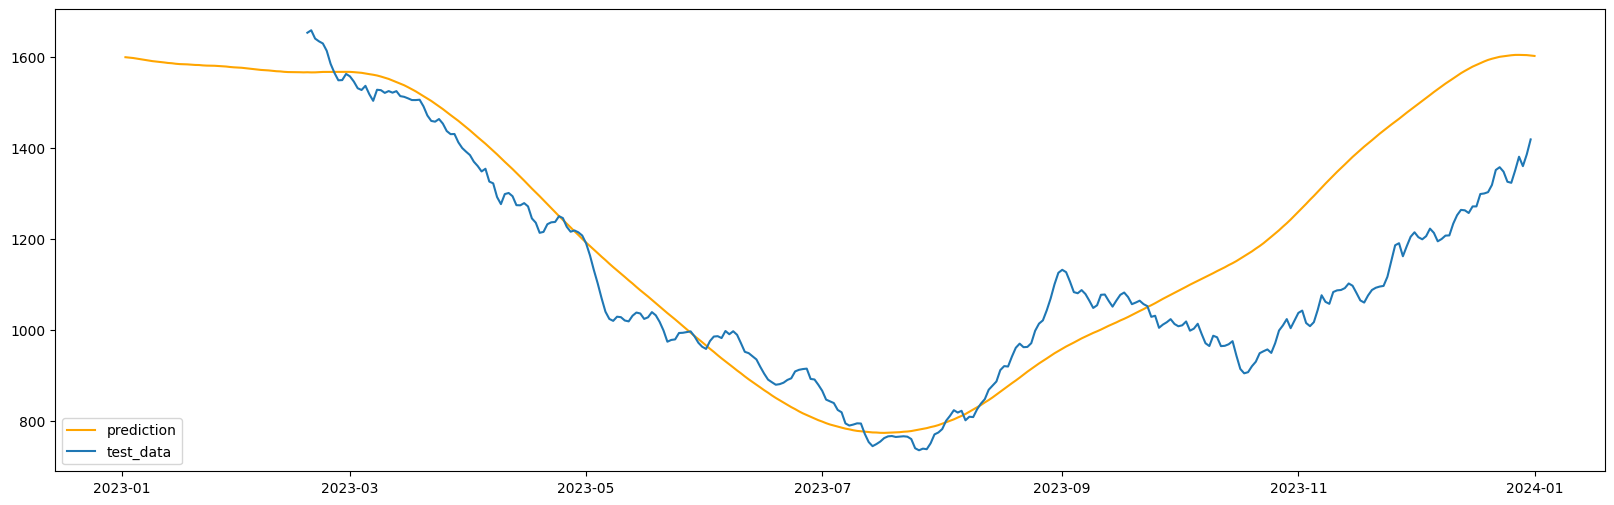

In [326]:
prediction = forecast.loc[testing_treshold(forecast.ds), ["ds", "yhat"]]

plt.figure(figsize=FIGSIZE)
plt.plot(prediction.ds, prediction.yhat, color="orange", label="prediction")
plt.plot(test_rolling[target], label="test_data")
plt.legend()

'predition error is 0.0973%'

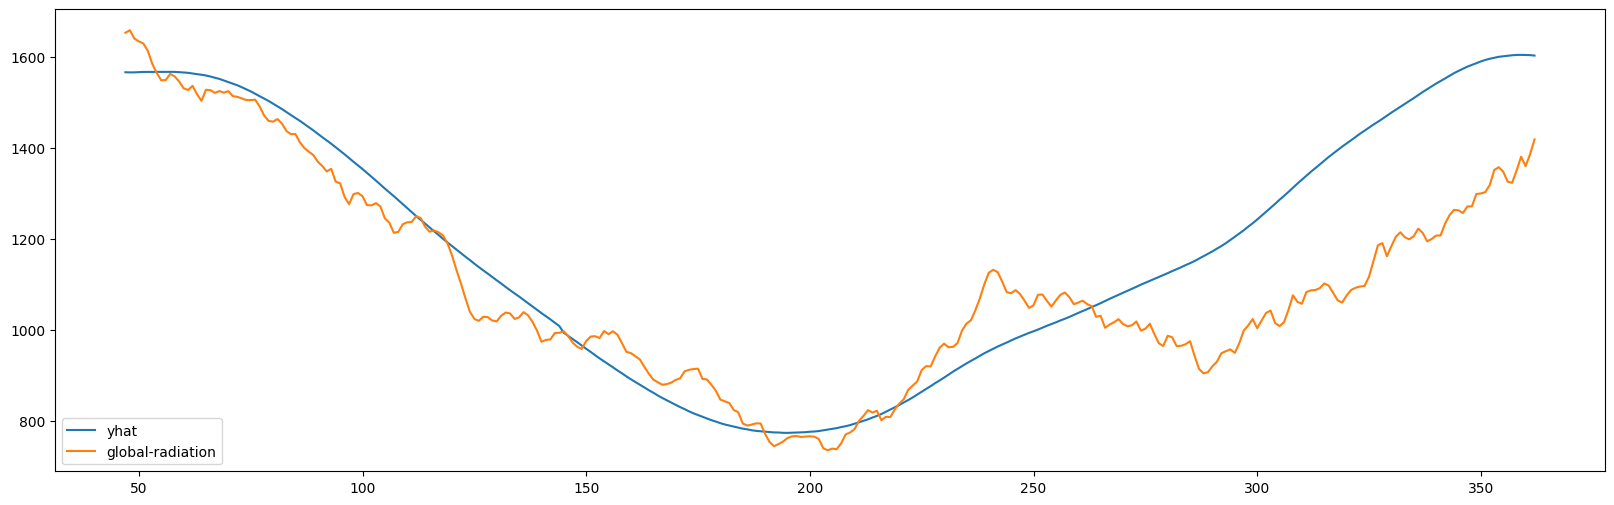

In [327]:
from sklearn.metrics import mean_absolute_percentage_error as mape

prediction_renamed = pd.DataFrame({idx: prediction.ds, "yhat": prediction.yhat})
comparison = test_rolling.merge(prediction_renamed, on=idx)
comparison = comparison.loc[(comparison.yhat.notna()) & (comparison[target].notna()),]

comparison[["yhat", target]].plot(figsize=FIGSIZE)

error = mape(comparison[target], comparison.yhat)
f"predition error is {error:.4f}%"

In [328]:
all_years = by_day.copy()
all_years["doy"] = by_day.index.day_of_year
all_years = make_rolling_window(all_years.groupby("doy").mean(), 28)

'historical error is 0.1219%'

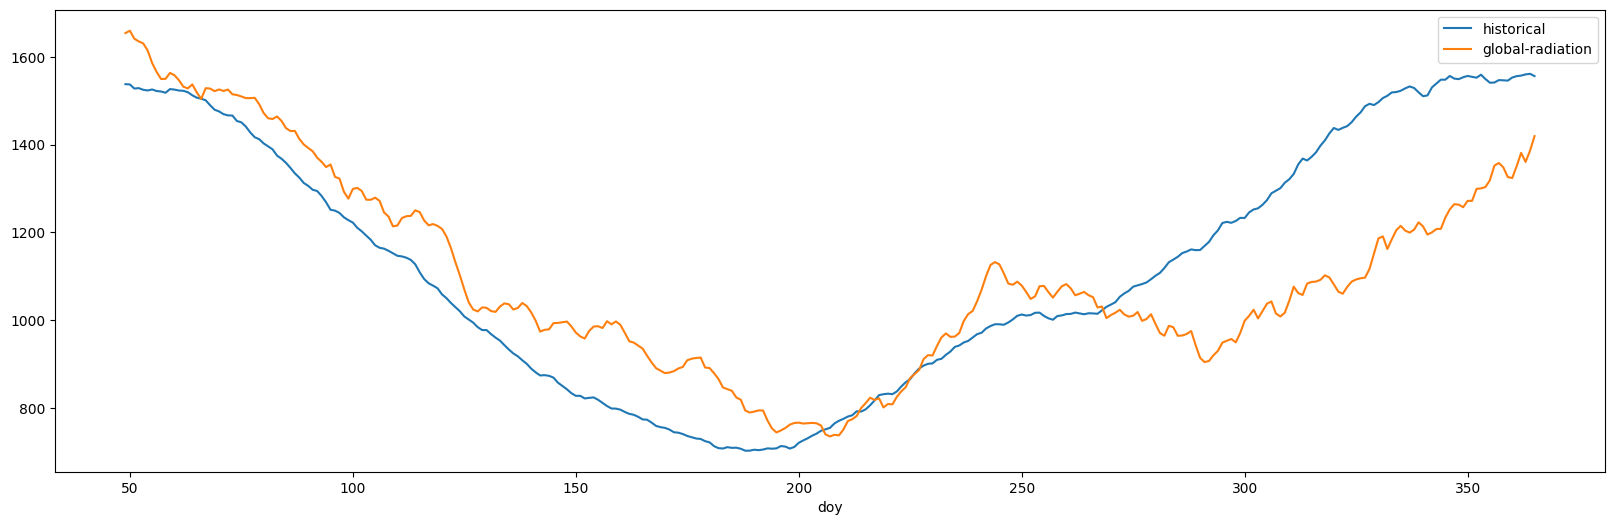

In [329]:
last_year = test_rolling.copy()
last_year["doy"] = last_year.index.day_of_year
last_year
last_year = last_year.groupby("doy").mean()

merged = all_years.merge(last_year[[target]], on="doy").rename(
    columns={f"{target}_x": "historical", f"{target}_y": target}
)

merged = merged.loc[
    (merged.historical.notna()) & (merged[target].notna()), ["historical", target]
]
merged.plot(figsize=FIGSIZE)

error_test = mape(merged[target], merged.historical)
f"historical error is {error_test:.4f}%"

In [330]:
xgb_df = make_rolling_window(by_day).copy()
xgb_df["lag1"] = (xgb_df.index - pd.DateOffset(years=1)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag2"] = (xgb_df.index - pd.DateOffset(years=2)).map(
    train_rolling[target].to_dict()
)
xgb_df["lag_history"] = xgb_df.index.day_of_year.map(all_years[target].to_dict())
xgb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8586 entries, 2000-09-22 11:30:00 to 2024-07-31 11:30:00
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   global-radiation           8538 non-null   float64
 1   total-precipitation        8489 non-null   float64
 2   relative-humidity          8538 non-null   float64
 3   temperature-last-hour-max  8440 non-null   float64
 4   temperature-last-hour-min  8440 non-null   float64
 5   wind-speed                 8316 non-null   float64
 6   wind-speed-max-gust        8169 non-null   float64
 7   lag1                       0 non-null      float64
 8   lag2                       0 non-null      float64
 9   lag_history                7948 non-null   float64
dtypes: float64(10)
memory usage: 737.9 KB


In [331]:
feats = []
for c in xgb_df.columns:
    if c == target:
        continue
    if abs(xgb_df.corr()[target][c]) >= 0.3:
        feats.append(c)
print(feats)

xgb_train = xgb_df.loc[training_threshold(xgb_df.index)]
xgb_test = xgb_df.loc[testing_treshold(xgb_df.index)]


def split_x_y_xgb(df, feats, target):
    return df.loc[df[target].notna(), feats], df.loc[df[target].notna(), target]


X_train, y_train = split_x_y_xgb(xgb_train, feats, target)
X_test, y_test = split_x_y_xgb(xgb_test, feats, target)

import xgboost as xgb

reg = xgb.XGBRegressor(
    base_score=1.0,
    booster="gbtree",
    n_estimators=1000,
    early_stopping_rounds=100,
    objective="reg:linear",
    max_depth=3,
    learning_rate=0.1,
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

['total-precipitation', 'relative-humidity', 'temperature-last-hour-max', 'temperature-last-hour-min', 'wind-speed', 'wind-speed-max-gust', 'lag_history']
[0]	validation_0-rmse:1098.55557	validation_1-rmse:1090.49869
[100]	validation_0-rmse:53.93686	validation_1-rmse:65.93866


/home/fellipessanha/solar-studies/venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:54:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:47.91632	validation_1-rmse:64.08386
[300]	validation_0-rmse:43.40443	validation_1-rmse:64.29630
[328]	validation_0-rmse:42.26451	validation_1-rmse:64.39311


XGBRegressor(base_score=1.0, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

<Axes: >

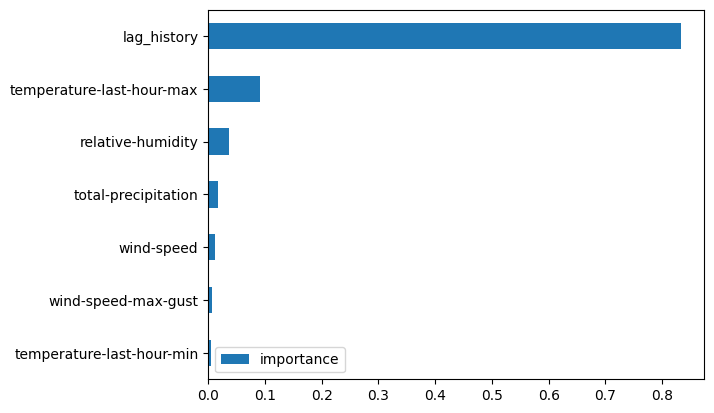

In [332]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
).sort_values("importance")

feature_importance.plot(kind="barh")

In [333]:
xgb_prediction = reg.predict(X_test)

prediction = pd.DataFrame(
    data=xgb_prediction, index=X_test.index, columns=["prediction"]
)
prediction = prediction.merge(y_test, left_index=True, right_index=True)

xgb error = 0.0482


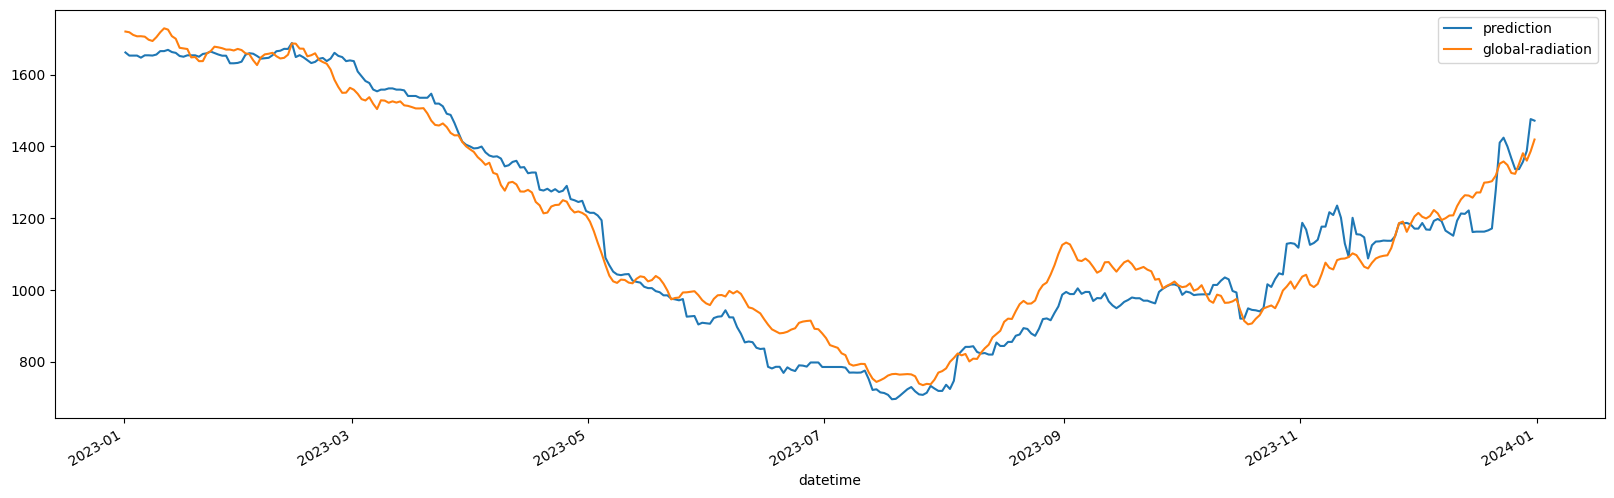

In [334]:
prediction.plot(figsize=FIGSIZE)

xgb_error = mape(prediction[target], prediction.prediction)
print(f"xgb error = {xgb_error:.4f}")